# 1.Version

In [2]:
import tensorflow as tf
print(tf.__version__)

#https://github.com/adapt-python/adapt/issues/118

2.16.1


# 2.Imports 

In [1]:
# Importing the required packages
import pandas as pd
import numpy as np
import os, shutil
import math
import matplotlib.pyplot as plt

import urllib.request
from tqdm import tqdm
from PIL import Image
import cv2
import pickle


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from keras.metrics import F1Score

import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model #-> Versão 2.12
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, GlobalAveragePooling2D, concatenate #-> Versão 2.12
from tensorflow.keras.optimizers import RMSprop, Adam #-> Versão 2.12
from tensorflow.keras.applications import VGG16, ResNet101, ResNet101V2, InceptionV3
import keras.backend as K
from tensorflow.keras.models import load_model 
from tensorflow.keras.utils import to_categorical


- **md5hash**: A unique identifier for each image.
- **fitzpatrick_scale**: The Fitzpatrick scale value for the skin type in the image.
- **fitzpatrick_centaur**: Another scale related to the Fitzpatrick scale, potentially adjusted or annotated differently.
- **label**: The target variable indicating the skin condition diagnosed in the image.
- **nine_partition_label** and **three_partition_label**: These columns seem to categorize conditions into broader groups.
- **qc**: A column that might relate to quality control or other annotations, which is empty in the first few rows.
- **url**: The URL of the image of the skin lesion.
- **url_alphanum**: A version of the URL with only alphanumeric characters, likely for easier processing or identification.


In [3]:
# Getting the current working directory
directory = os.getcwd()
directory

'c:\\Users\\Filipe\\VSCODE PROJECTS\\project_DL'

# 3.Images DownLoad and Preprocessing

In [4]:
df = pd.read_csv('c:\\Users\\Filipe\\VSCODE PROJECTS\\project_DL\\fitzpatrick17k.csv', sep=',')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                16577 non-null  object
 1   fitzpatrick_scale      16577 non-null  int64 
 2   fitzpatrick_centaur    16577 non-null  int64 
 3   label                  16577 non-null  object
 4   nine_partition_label   16577 non-null  object
 5   three_partition_label  16577 non-null  object
 6   qc                     504 non-null    object
 7   url                    16536 non-null  object
 8   url_alphanum           16577 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


In [6]:
df['url'].isna().sum()

41

In [7]:
# Dropping the rows with missing values
df.dropna(subset=['url'], inplace=True)

In [8]:
def download_images_and_check_missing(df, target_dir):
    # Inicializa contadores para diferentes tipos de falhas
    total_missing_url = 0
    total_url_not_found = 0
    total_failed_downloads = 0
    total_downloaded = 0

    # Garante que o diretório de destino exista
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
    }

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        if pd.isnull(row['url']):
            total_missing_url += 1
            continue
        
        url = row['url']
        filename = os.path.join(target_dir, f"{row['md5hash']}.jpg")

        if os.path.exists(filename):
            total_downloaded += 1
            continue

        req = urllib.request.Request(url, headers=headers)

        try:
            with urllib.request.urlopen(req) as response, open(filename, 'wb') as out_file:
                data = response.read()
                out_file.write(data)
                total_downloaded += 1
        except urllib.error.HTTPError as e:
            if e.code == 404:
                total_url_not_found += 1
                print(f"URL not found {url}, skipping.")
            else:
                total_failed_downloads += 1
                print(f"Failed to download {url}: HTTP Error {e.code}")
        except Exception as e:
            total_failed_downloads += 1
            print(f"Failed to download {url}: {str(e)}")

    # Imprime um resumo dos resultados
    print(f"Total de imagens com URL faltando: {total_missing_url}")
    print(f"Total de URLs não encontradas (HTTP 404): {total_url_not_found}")
    print(f"Total de falhas no download: {total_failed_downloads}")
    print(f"Total de imagens baixadas ou já presentes: {total_downloaded}")

# Supondo que 'df' é o seu DataFrame e 'images' é o seu diretório de destino
download_images_and_check_missing(df, 'images')


 77%|███████▋  | 12659/16536 [00:03<00:00, 5710.88it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=6724: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Failed to download http://atlasdermatologico.com.br/img?imageId=4030: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 80%|████████  | 13232/16536 [00:05<00:05, 647.52it/s] 

Failed to download http://atlasdermatologico.com.br/img?imageId=5399: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Failed to download http://atlasdermatologico.com.br/img?imageId=4505: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 82%|████████▏ | 13639/16536 [00:07<00:06, 472.45it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=8362: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Failed to download http://atlasdermatologico.com.br/img?imageId=4031: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 84%|████████▍ | 13932/16536 [00:09<00:07, 339.90it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=8363: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 90%|████████▉ | 14819/16536 [00:10<00:03, 543.89it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=2767: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 92%|█████████▏| 15238/16536 [00:11<00:02, 527.75it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=2766: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


100%|██████████| 16536/16536 [00:12<00:00, 1350.52it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=8364: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Total de imagens com URL faltando: 0
Total de URLs não encontradas (HTTP 404): 0
Total de falhas no download: 10
Total de imagens baixadas ou já presentes: 16526


Since we have 41 missing URLs and 10 that aren't valid we are going to drop this rows.

In [9]:
invalid_urls = [
    "http://atlasdermatologico.com.br/img?imageId=6724",
    "http://atlasdermatologico.com.br/img?imageId=4030",
    "http://atlasdermatologico.com.br/img?imageId=5399",
    "http://atlasdermatologico.com.br/img?imageId=4505",
    "http://atlasdermatologico.com.br/img?imageId=8362",
    "http://atlasdermatologico.com.br/img?imageId=4031",
    "http://atlasdermatologico.com.br/img?imageId=8363",
    "http://atlasdermatologico.com.br/img?imageId=2767",
    "http://atlasdermatologico.com.br/img?imageId=2766",
    "http://atlasdermatologico.com.br/img?imageId=8364"
]

df = df[~df['url'].isin(invalid_urls)]

In [10]:
# Path to the directory containing the images
images_dir = 'c:\\Users\\Filipe\\VSCODE PROJECTS\\project_DL\\images'

# List of problematic images
problematic_images = []

# Verify the integrity of each image
for filename in tqdm(os.listdir(images_dir)):
    if not filename.endswith('.jpg'):  # Ignore non-image files
        continue
    
    try:
        img_path = os.path.join(images_dir, filename)
        with Image.open(img_path) as img:
            img.verify()  # Try to open the image and check for any errors
    except Exception as e:
        print(f"Erro ao verificar a imagem {filename}: {e}")
        problematic_images.append(filename)

# Print the total number of problematic images
print(f"Total de imagens problemáticas: {len(problematic_images)}")


  0%|          | 0/16526 [00:00<?, ?it/s]

100%|██████████| 16526/16526 [00:11<00:00, 1469.96it/s]

Total de imagens problemáticas: 0


In [11]:
base_dir = "images"

# Define the subdirectories
train_dir = "POPULATION\\train"
val_dir = "POPULATION\\val"
test_dir = "POPULATION\\test"

# Check if directories already exist
if not (os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir)):
    # Create the directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Split the data into train, validation, and test sets
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

    df_train_val, df_test = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)
    df_train, df_val = train_test_split(df_train_val, test_size=val_ratio/(train_ratio+val_ratio), stratify=df_train_val['label'], random_state=42)

    # Function to copy images to respective directories
    def copy_images(df, dest_dir):
        for _, row in df.iterrows():
            file_name = f"{row['md5hash']}.jpg"
            source_path = os.path.join(base_dir, file_name)

            if not os.path.isfile(source_path):
                print(f"File not found: {source_path}")
                continue

            label_dir = os.path.join(dest_dir, row['label'])
            os.makedirs(label_dir, exist_ok=True)

            destination_path = os.path.join(label_dir, file_name)
            shutil.copy(source_path, destination_path)

    copy_images(df_train, train_dir)
    copy_images(df_val, val_dir)
    copy_images(df_test, test_dir)


# Function to count images in a directory
def count_images(dir_path):
    count = 0
    for _, dirs, files in os.walk(dir_path):
        count += len(files)
    return count

print(f"Total images in training: {count_images(train_dir)}")
print(f"Total images in validation: {count_images(val_dir)}")
print(f"Total images in testing: {count_images(test_dir)}")

Total images in training: 13220
Total images in validation: 1653
Total images in testing: 1653


# 4.Functions

In [12]:
def training_plots(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1_metric']  
    val_f1 = history.history['val_f1_metric'] 

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation F1 score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, 'bo', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'b', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
#https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras
from tensorflow.keras import backend as K

def f1_metric(true, pred):
    # predLabels = K.argmax(pred, axis=-1)  # Uncomment these lines if 'pred' needs to be converted
    # pred = K.one_hot(predLabels, 4)      # from probabilities to one-hot encoded values

    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)
    
    return weighted_f1  # Return the weighted F1 score directly


# 7.CallBacks - Early Stopping

In [60]:
callbacks_list_f1 = [
    keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_f1_metric',
        mode='max' 
    ),
]

For all our multi input models we decided to use callbacks with EarlyStopping based on the 'val_f1_metric' as our objective is to maximize this metric on unseen data (test set). We saw on the previous models that the f1 metric was still getting higher, but the model was getting stopped because of the loss. We will take this approach so that we can maximize the f1 metric, even if that means we have overfitting and a higher loss. This decision will help us have better overall results on unseen data (test set) on the main metrics (accuracy and f1) as we will check later in the report.

# 10. Multi input 

## 10.1 Preprocessing

In [18]:
# Define the paths to your validation and test directories
train_directory = r'C:\Users\Filipe\VSCODE PROJECTS\project_DL\POPULATION\train'
val_directory = r'C:\Users\Filipe\VSCODE PROJECTS\project_DL\POPULATION\val'
test_directory = r'C:\Users\Filipe\VSCODE PROJECTS\project_DL\POPULATION\test'

# Function to create mapping between MD5 hashes and fitzpatrick_scale values
def create_mapping_fitzpatrick(directory):
    md5hash_to_fitzpatrick = {}
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        for filename in os.listdir(folder_path):
            md5hash = filename[:-4]
            fitzpatrick_scale = df[df['md5hash'] == md5hash]['fitzpatrick_scale'].iloc[0]
            md5hash_to_fitzpatrick[filename] = fitzpatrick_scale
    return md5hash_to_fitzpatrick

# Create mappings for validation and test datasets
train_md5hash_to_fitzpatrick = create_mapping_fitzpatrick(train_directory)
val_md5hash_to_fitzpatrick = create_mapping_fitzpatrick(val_directory)
test_md5hash_to_fitzpatrick = create_mapping_fitzpatrick(test_directory)


In [19]:
# Function to create mapping between MD5 hashes and fitzpatrick_scale values
def create_mapping_label(directory):
    md5hash_to_fitzpatrick = {}
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        for filename in os.listdir(folder_path):
            md5hash = filename[:-4]
            fitzpatrick_scale = df[df['md5hash'] == md5hash]['label'].iloc[0]
            md5hash_to_fitzpatrick[filename] = fitzpatrick_scale
    return md5hash_to_fitzpatrick

# Create mappings for validation and test datasets
train_md5hash_to_label = create_mapping_label(train_directory)
val_md5hash_to_label = create_mapping_label(val_directory)
test_md5hash_to_label = create_mapping_label(test_directory)


In [20]:
def load_and_preprocess_images(directory, md5hash_to_label):
    images = []
    labels = []
    label_mapping = {label: index for index, label in enumerate(sorted(set(df['label'])))} 
    for md5hash, label in md5hash_to_label.items():
        label = md5hash_to_label[md5hash]
        filename = label + '\\' + md5hash
        filepath = os.path.join(directory, filename)
        image = cv2.imread(filepath)
        if image is not None:
            image = cv2.resize(image, (224, 224))  # Resize images to fit input shape
            image = image / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label_mapping[label])  # Convert class name to integer label
    return np.array(images), np.array(labels)

# Load and preprocess images for training
train_images, train_labels = load_and_preprocess_images(train_directory, train_md5hash_to_label)
val_images, val_labels = load_and_preprocess_images(val_directory, val_md5hash_to_label)
test_images, test_labels = load_and_preprocess_images(test_directory, test_md5hash_to_label)

## 10.2 GoogleNet (InceptionV3)

In [27]:
# Load pre-trained InceptionV3 model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Define input layers
image_input = Input(shape=(224, 224, 3))
numerical_input = Input(shape=(1,))

# Apply base model to image input
image_features = base_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)

# Concatenate image features with numerical input
concatenated = concatenate([image_features, numerical_input])

# Add custom classification layers
x = Dense(256, activation='relu')(concatenated)
predictions = Dense(114, activation='softmax')(x)

# Create model
multi_input_gnet = Model(inputs=[image_input, numerical_input], outputs=predictions)

# Compile model
multi_input_gnet.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_metric])

train_numerical_data = np.array(list(train_md5hash_to_fitzpatrick.values()))
val_numerical_data = np.array(list(val_md5hash_to_fitzpatrick.values()))
test_numerical_data = np.array(list(test_md5hash_to_fitzpatrick.values()))

# Convert labels to one-hot encoded vectors
train_labels_onehot = to_categorical(train_labels, num_classes=114)
val_labels_onehot = to_categorical(val_labels, num_classes=114)
test_labels_onehot = to_categorical(test_labels, num_classes=114)

# Train the model
history_multi_input_gnet = multi_input_gnet.fit(
    x=[train_images, train_numerical_data],
    y=train_labels_onehot,
    epochs=20,
    callbacks = callbacks_list_f1,
    batch_size=256,
    validation_data=([val_images, val_numerical_data], val_labels_onehot)
)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - categorical_accuracy: 0.0621 - f1_metric: 0.0195 - loss: 4.5104 - val_categorical_accuracy: 0.1198 - val_f1_metric: 0.0578 - val_loss: 4.0291
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - categorical_accuracy: 0.1509 - f1_metric: 0.0499 - loss: 3.8176 - val_categorical_accuracy: 0.1567 - val_f1_metric: 0.0958 - val_loss: 3.7539
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - categorical_accuracy: 0.2170 - f1_metric: 0.0842 - loss: 3.4118 - val_categorical_accuracy: 0.1748 - val_f1_metric: 0.1204 - val_loss: 3.6101
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - categorical_accuracy: 0.2587 - f1_metric: 0.1102 - loss: 3.1540 - val_categorical_accuracy: 0.1948 - val_f1_metric: 0.1309 - val_loss: 3.5598
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - categorical_accuracy: 0.2967 - f1_metric: 0.1340 - loss: 2.9474 - val_categorical_accuracy: 0.2063 - val_f1_metric: 0.1534 - val_loss: 3.4757
Epoch 6/20
52/52 ━━━━━━━━

### 10.2.1 Evaluate model

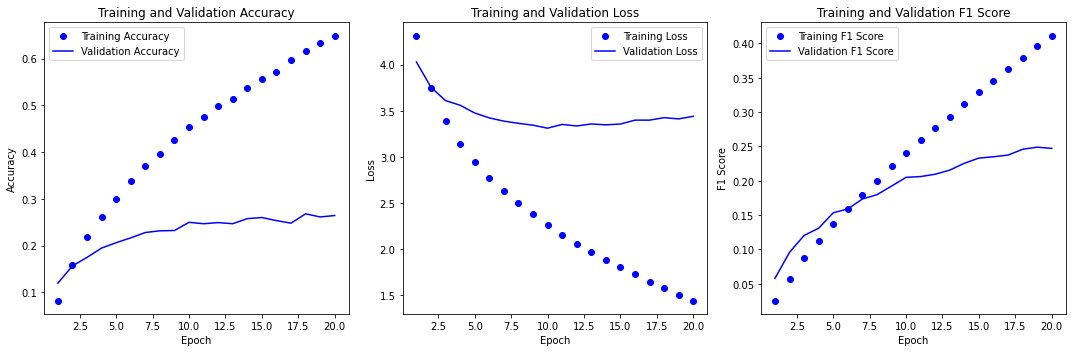

Training Loss: 1.3138161897659302
Training Categorical Accuracy: 0.6922844052314758
Training Weighted F1-score: 0.5822300910949707
Validation Loss: 3.4394338130950928
Validation Categorical Accuracy: 0.26436781883239746
Validation Weighted F1-score: 0.26845407485961914
Test Loss: 3.3852505683898926
Test Categorical Accuracy: 0.2698124647140503
Test Weighted F1-score: 0.2846326529979706


In [115]:
training_plots(history_multi_input_gnet)

test_loss, test_categorical_accuracy, test_f1_metric = multi_input_gnet.evaluate([test_images, test_numerical_data], test_labels_onehot, verbose=0)
validation_loss, validation_categorical_accuracy, validation_f1_metric = multi_input_gnet.evaluate([val_images, val_numerical_data], val_labels_onehot, verbose=0)
train_loss, train_categorical_accuracy, train_f1_metric = multi_input_gnet.evaluate([train_images, train_numerical_data], train_labels_onehot, verbose=0)

# Print Loss, Categorical Accuracy, and Weighted F1 Score for Training and Validation Sets
print(f"Training Loss: {train_loss}\nTraining Categorical Accuracy: {train_categorical_accuracy}\nTraining Weighted F1-score: {train_f1_metric}")
print(f"Validation Loss: {validation_loss}\nValidation Categorical Accuracy: {validation_categorical_accuracy}\nValidation Weighted F1-score: {validation_f1_metric}")
print(f"Test Loss: {test_loss}\nTest Categorical Accuracy: {test_categorical_accuracy}\nTest Weighted F1-score: {test_f1_metric}")

We decided to start running 50 epochs because we saw the f1 score was still improving for the 20 epochs. We also used dropout to help with overfitting

## 10.3 GoogleNet (InceptionV3) with dropout

In [62]:
# Load pre-trained InceptionV3 model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Define input layers
image_input = Input(shape=(224, 224, 3))
numerical_input = Input(shape=(1,))

# Apply base model to image input
image_features = base_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)

# Concatenate image features with numerical input
concatenated = concatenate([image_features, numerical_input])

# Add custom classification layers
x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.4)(x)
predictions = Dense(114, activation='softmax')(x) 

# Create model
multi_input_gnet_dp = Model(inputs=[image_input, numerical_input], outputs=predictions)

# Compile model
multi_input_gnet_dp.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_metric])

train_numerical_data = np.array(list(train_md5hash_to_fitzpatrick.values()))
val_numerical_data = np.array(list(val_md5hash_to_fitzpatrick.values()))
test_numerical_data = np.array(list(test_md5hash_to_fitzpatrick.values()))

# Convert labels to one-hot encoded vectors
train_labels_onehot = to_categorical(train_labels, num_classes=114)
val_labels_onehot = to_categorical(val_labels, num_classes=114)
test_labels_onehot = to_categorical(test_labels, num_classes=114)

# Train the model
history_multi_input_gnet_dp = multi_input_gnet_dp.fit(
    x=[train_images, train_numerical_data],
    y=train_labels_onehot,
    epochs=50,
    callbacks = callbacks_list_f1,
    batch_size=256,
    validation_data=([val_images, val_numerical_data], val_labels_onehot)
)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - categorical_accuracy: 0.0355 - f1_metric: 0.0146 - loss: 4.6997 - val_categorical_accuracy: 0.0907 - val_f1_metric: 0.0355 - val_loss: 4.2552
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - categorical_accuracy: 0.0796 - f1_metric: 0.0279 - loss: 4.2446 - val_categorical_accuracy: 0.1101 - val_f1_metric: 0.0562 - val_loss: 4.0218
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - categorical_accuracy: 0.1155 - f1_metric: 0.0416 - loss: 3.9914 - val_categorical_accuracy: 0.1289 - val_f1_metric: 0.0737 - val_loss: 3.8730
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - categorical_accuracy: 0.1389 - f1_metric: 0.0527 - loss: 3.8081 - val_categorical_accuracy: 0.1488 - val_f1_metric: 0.0824 - val_loss: 3.7464
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - categorical_accuracy: 0.1559 - f1_metric: 0.0607 - loss: 3.6982 - val_categorical_accuracy: 0.1585 - val_f1_metric: 0.0895 - val_loss: 3.6768
Epoch 6/50
52/52 ━━━━━━━━

### 10.3.1 Evaluate model

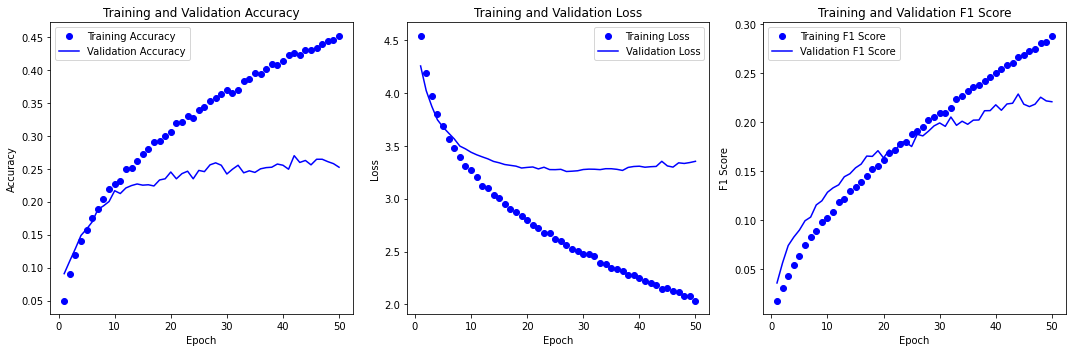

Training Loss: 1.4215595722198486
Training Categorical Accuracy: 0.6874432563781738
Training Weighted F1-score: 0.5259280204772949
Validation Loss: 3.3534674644470215
Validation Categorical Accuracy: 0.25226861238479614
Validation Weighted F1-score: 0.23881927132606506
Test Loss: 3.3046352863311768
Test Categorical Accuracy: 0.26134300231933594
Test Weighted F1-score: 0.2478131651878357


In [63]:
training_plots(history_multi_input_gnet_dp)

test_loss, test_categorical_accuracy, test_f1_metric = multi_input_gnet_dp.evaluate([test_images, test_numerical_data], test_labels_onehot, verbose=0)
validation_loss, validation_categorical_accuracy, validation_f1_metric = multi_input_gnet_dp.evaluate([val_images, val_numerical_data], val_labels_onehot, verbose=0)
train_loss, train_categorical_accuracy, train_f1_metric = multi_input_gnet_dp.evaluate([train_images, train_numerical_data], train_labels_onehot, verbose=0)

# Print Loss, Categorical Accuracy, and Weighted F1 Score for Training and Validation Sets
print(f"Training Loss: {train_loss}\nTraining Categorical Accuracy: {train_categorical_accuracy}\nTraining Weighted F1-score: {train_f1_metric}")
print(f"Validation Loss: {validation_loss}\nValidation Categorical Accuracy: {validation_categorical_accuracy}\nValidation Weighted F1-score: {validation_f1_metric}")
print(f"Test Loss: {test_loss}\nTest Categorical Accuracy: {test_categorical_accuracy}\nTest Weighted F1-score: {test_f1_metric}")

## 10.4 ResNet101V2 with dropout

In [35]:
# Load pre-trained ResNet101V2 model without top layers
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Define input layers
image_input = Input(shape=(224, 224, 3))
numerical_input = Input(shape=(1,))

# Apply base model to image input
image_features = base_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)

# Concatenate image features with numerical input
concatenated = concatenate([image_features, numerical_input])

# Add custom classification layers
x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.4)(x)  # Add dropout with a dropout rate of 0.4
predictions = Dense(114, activation='softmax')(x) 

# Create model
multi_input_resnet = Model(inputs=[image_input, numerical_input], outputs=predictions)

# Compile model
multi_input_resnet.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_metric])

train_numerical_data = np.array(list(train_md5hash_to_fitzpatrick.values()))
val_numerical_data = np.array(list(val_md5hash_to_fitzpatrick.values()))
test_numerical_data = np.array(list(test_md5hash_to_fitzpatrick.values()))

# Convert labels to one-hot encoded vectors
train_labels_onehot = to_categorical(train_labels, num_classes=114)
val_labels_onehot = to_categorical(val_labels, num_classes=114)
test_labels_onehot = to_categorical(test_labels, num_classes=114)

# Train the model
history_multi_input_resnet_dropout = multi_input_resnet.fit(
    x=[train_images, train_numerical_data],
    y=train_labels_onehot,
    epochs=50,
    callbacks = callbacks_list_f1,
    batch_size=256,
    validation_data=([val_images, val_numerical_data], val_labels_onehot)
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 709s 13s/step - categorical_accuracy: 0.0670 - f1_metric: 0.0264 - loss: 4.5488 - val_categorical_accuracy: 0.1736 - val_f1_metric: 0.0933 - val_loss: 3.7225
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 684s 13s/step - categorical_accuracy: 0.1853 - f1_metric: 0.0837 - loss: 3.5388 - val_categorical_accuracy: 0.2166 - val_f1_metric: 0.1330 - val_loss: 3.4245
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 684s 13s/step - categorical_accuracy: 0.2697 - f1_metric: 0.1306 - loss: 3.0786 - val_categorical_accuracy: 0.2674 - val_f1_metric: 0.1730 - val_loss: 3.2135
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 680s 13s/step - categorical_accuracy: 0.3375 - f1_metric: 0.1762 - loss: 2.7458 - val_categorical_accuracy: 0.2922 - val_f1_metric: 0.2060 - val_loss: 3.1039
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 683s 13s/step - categorical_accuracy: 0.3987 - f1_metric: 0.2238 - loss: 2.4445 - val_categorical_accuracy: 0.3043 - val_f1_metric: 0.2286 - val_loss: 3.0209
Epoch 6/50
52/52 ━━━

### 10.4.1 Evaluate model

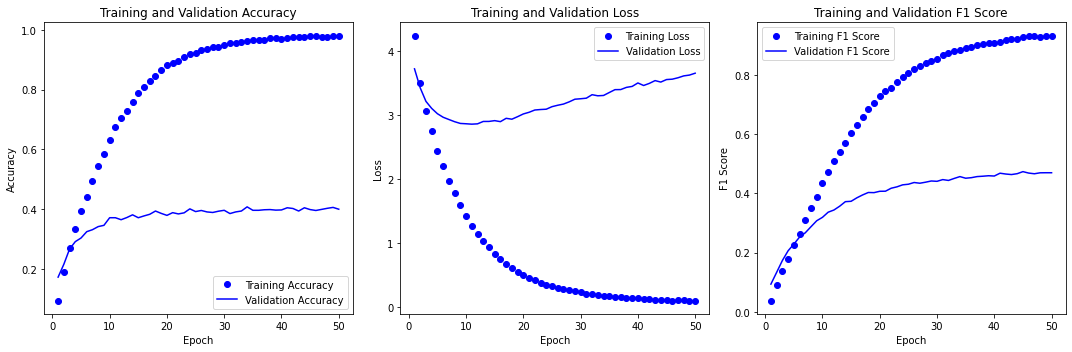

Training Loss: 0.007244527339935303
Training Categorical Accuracy: 0.9996974468231201
Training Weighted F1-score: 0.9965306520462036
Validation Loss: 3.6543118953704834
Validation Categorical Accuracy: 0.40048396587371826
Validation Weighted F1-score: 0.49421313405036926
Test Loss: 3.8258554935455322
Test Categorical Accuracy: 0.37386569380760193
Test Weighted F1-score: 0.47130873799324036


In [56]:
training_plots(history_multi_input_resnet_dropout)

test_loss, test_categorical_accuracy, test_f1_metric = multi_input_resnet.evaluate([test_images, test_numerical_data], test_labels_onehot, verbose=0)
validation_loss, validation_categorical_accuracy, validation_f1_metric = multi_input_resnet.evaluate([val_images, val_numerical_data], val_labels_onehot, verbose=0)
train_loss, train_categorical_accuracy, train_f1_metric = multi_input_resnet.evaluate([train_images, train_numerical_data], train_labels_onehot, verbose=0)

# Print Loss, Categorical Accuracy, and Weighted F1 Score for Training and Validation Sets
print(f"Training Loss: {train_loss}\nTraining Categorical Accuracy: {train_categorical_accuracy}\nTraining Weighted F1-score: {train_f1_metric}")
print(f"Validation Loss: {validation_loss}\nValidation Categorical Accuracy: {validation_categorical_accuracy}\nValidation Weighted F1-score: {validation_f1_metric}")
print(f"Test Loss: {test_loss}\nTest Categorical Accuracy: {test_categorical_accuracy}\nTest Weighted F1-score: {test_f1_metric}")